In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import sys
sys.path.insert(0,"..")

In [3]:
import os

import torch
from torch.utils.data import SubsetRandomSampler

from src.dataset import ImageDataset
from src.utils import get_indices



import numpy as np
%matplotlib inline

import model
import training
import utils

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Dataset part used for testing
TEST_SPLIT = 0.15
# Batch size for training. Limited by GPU memory
BATCH_SIZE = 5
# Dataset folder used
DATASET_USED = 'e9_5_GLM87a_cycle1_8_8'
#DATASET_USED = 'e12_5_slide7_round1_section1'
# Full Dataset path
DATASETS = ['e9_5_GLM87a_cycle1_8_8', 'e12_5_slide7_round1_section1' , 'train', 'val']
ROOTDIR = '../data'

# Training Epochs
EPOCHS = 10



In [4]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

## 1 Initiate train and test loader

In [5]:
image_dataset = ImageDataset(ROOTDIR, DATASETS, normalize="mddinmax")


train_indices,validation_indices, test_indices = get_indices(len(image_dataset), image_dataset.root_dir, TEST_SPLIT, new=True)
train_sampler,validation_sampler, test_sampler = SubsetRandomSampler(train_indices),SubsetRandomSampler(validation_indices), SubsetRandomSampler(test_indices)

trainloader = torch.utils.data.DataLoader(image_dataset, BATCH_SIZE, sampler=train_sampler)
validationloader = torch.utils.data.DataLoader(image_dataset, BATCH_SIZE, sampler=validation_sampler)

testloader = torch.utils.data.DataLoader(image_dataset, 1, sampler=test_sampler)

/home/seifbenmustapha/miniconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [34]:
testloader = torch.utils.data.DataLoader(image_dataset, 3, sampler=test_sampler)

In [6]:
len(trainloader)

99

In [7]:
model

<module 'model' from '/home/seifbenmustapha8/deep-biomedicine-project/unet/model.py'>

## 1.1 Show example of images

torch.Size([5, 1, 1024, 1024])
torch.Size([5, 1024, 1024])


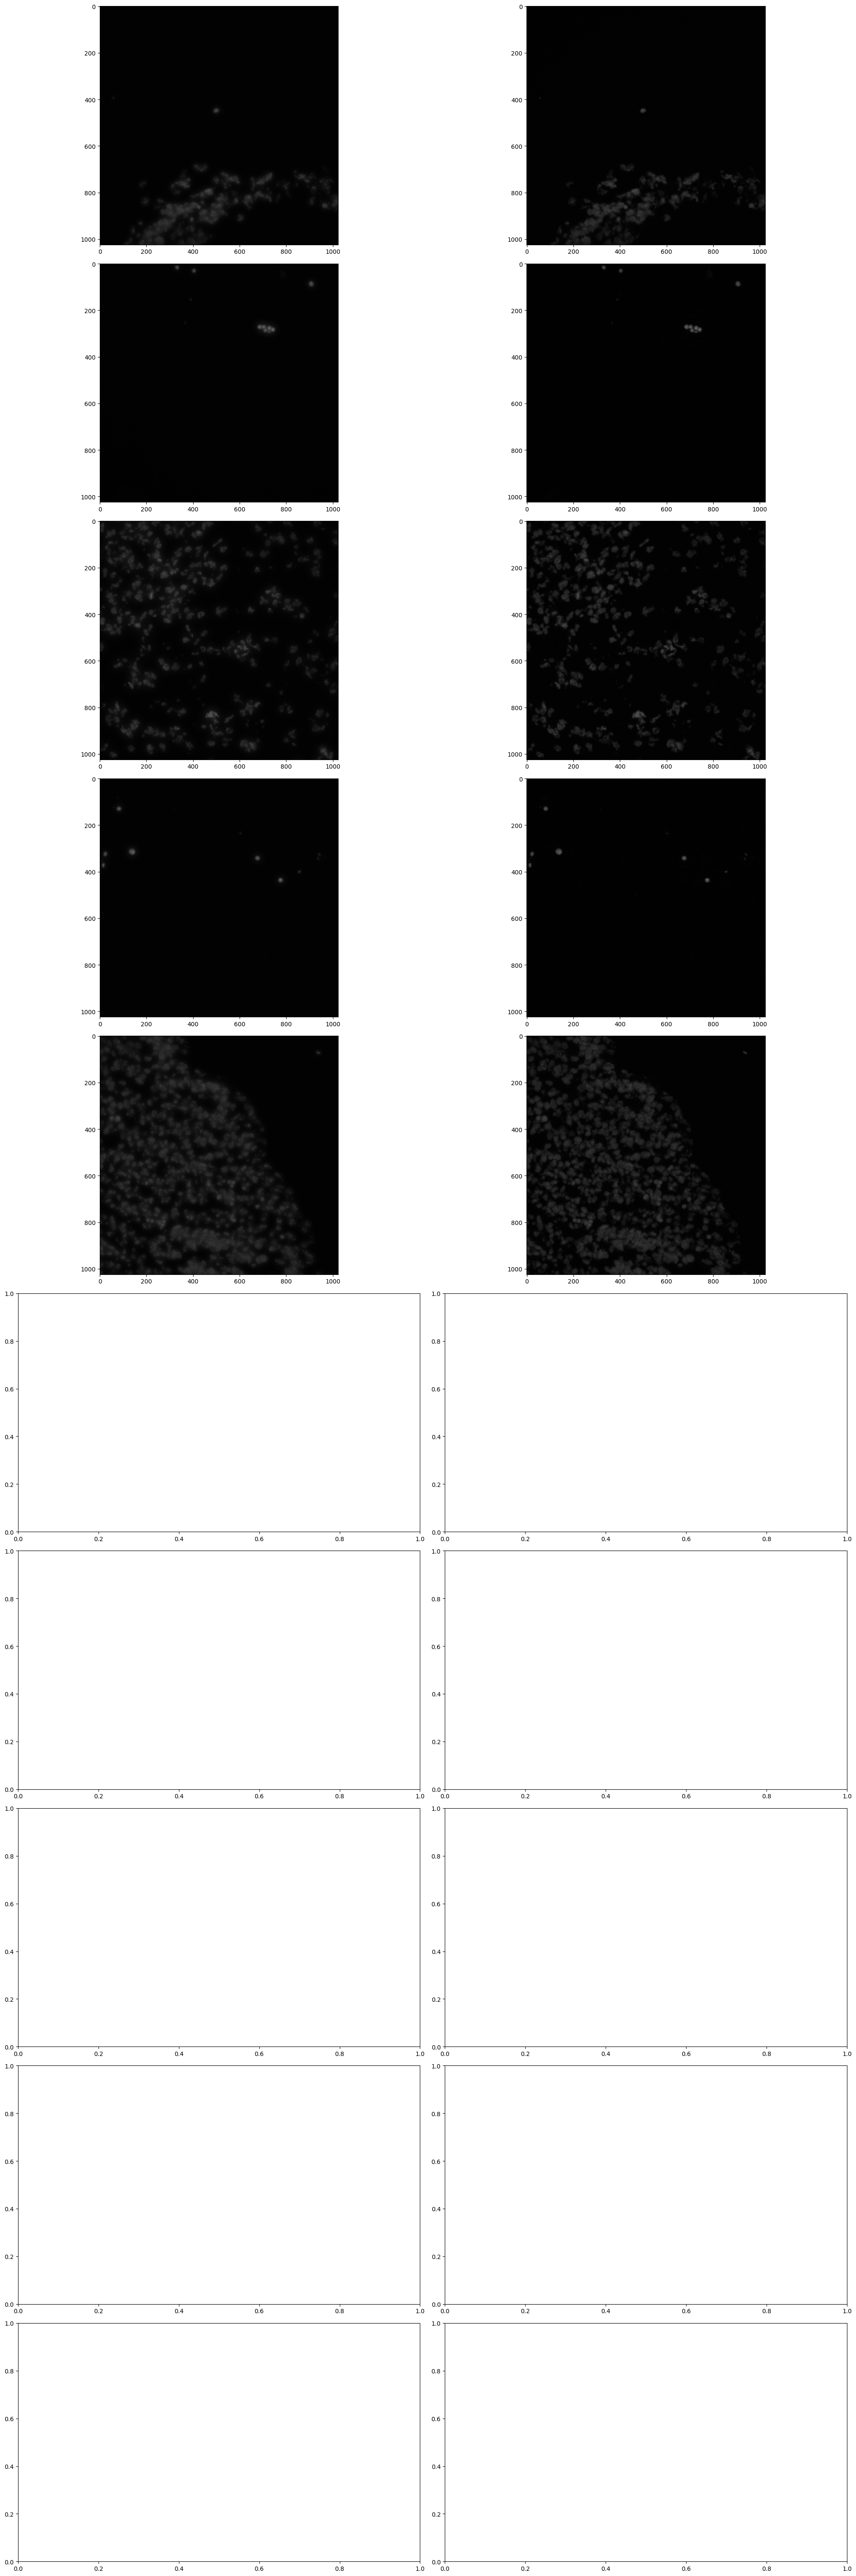

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=10, ncols=2, figsize=(20, 60))
for data in trainloader:
    print(data['input_image'].shape)
    input_image = data['input_image'].squeeze().permute(1, 2, 0)
    print(data['input_image'].squeeze().shape)
    
    output_image = data['output_image'].squeeze().permute(1, 2, 0)

    for i in range(input_image.shape[2]):
        ax[i,0].imshow(input_image[:,:,i], cmap='gray', vmin=0, vmax=16383, aspect='equal')
        ax[i,1].imshow(output_image[:,:,i], cmap='gray', vmin=0, vmax=16383, aspect='equal')
    break

plt.tight_layout()

In [9]:


# Training Epochs
EPOCHS = 100
# Filters used in UNet Model
filter_num = [16,32,64,128,256]

MODEL_NAME = f"UNet-{filter_num}.pt"

In [10]:
unet_model = model.UNet(filter_num).to(device)

In [11]:
pytorch_total_params = sum(p.numel() for p in unet_model.parameters())

In [12]:
pytorch_total_params

1940945

In [13]:
# Training
unet_trainer = training.Trainer(unet_model,device)

training_loss_record, validation_loss_record = unet_trainer.train(EPOCHS,trainloader,validationloader,mini_batch=100)

print(f'Training finished!')

Starting Training Process
Epoch: 001,  
 Training Loss:69.7621488,  
  Validation Loss:21.7375620,  
  Epoch: 002,  
 Training Loss:17.7518569,  
  Validation Loss:13.8575890,  
  Epoch: 003,  
 Training Loss:13.5020902,  
  Validation Loss:11.6814490,  
  Epoch: 004,  
 Training Loss:10.7611303,  
  Validation Loss:10.0328534,  
  Epoch: 005,  
 Training Loss:10.4100288,  
  Validation Loss:9.5283048,  
  Epoch: 006,  
 Training Loss:10.3479032,  
  Validation Loss:10.5169699,  
  Epoch: 007,  
 Training Loss:10.2301164,  
  Validation Loss:9.1290979,  
  Epoch: 008,  
 Training Loss:9.8038302,  
  Validation Loss:9.5498401,  
  Epoch: 009,  
 Training Loss:10.8103481,  
  Validation Loss:9.1397948,  
  Epoch: 010,  
 Training Loss:9.4167426,  
  Validation Loss:9.7124946,  
  Epoch: 011,  
 Training Loss:9.0570067,  
  Validation Loss:8.7512227,  
  Epoch: 012,  
 Training Loss:9.1991688,  
  Validation Loss:8.6872547,  
  Epoch: 013,  
 Training Loss:9.3049778,  
  Validation Loss:1

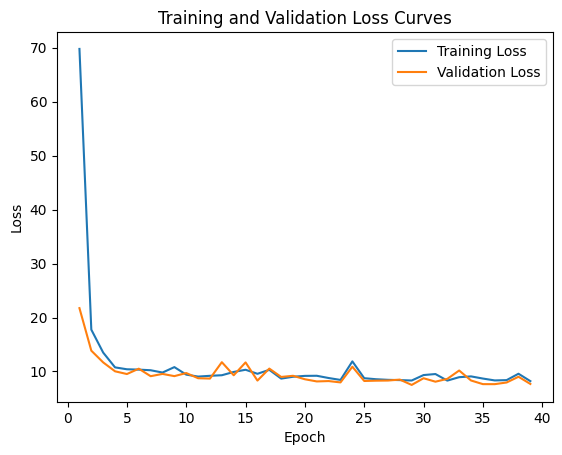

In [14]:
plt.plot(range(1, len(training_loss_record) + 1), training_loss_record, label='Training Loss')
plt.plot(range(1, len(validation_loss_record) + 1), validation_loss_record, label='Validation Loss')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
def plot_loss(num_epochs,train_losses):
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.title('Training Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

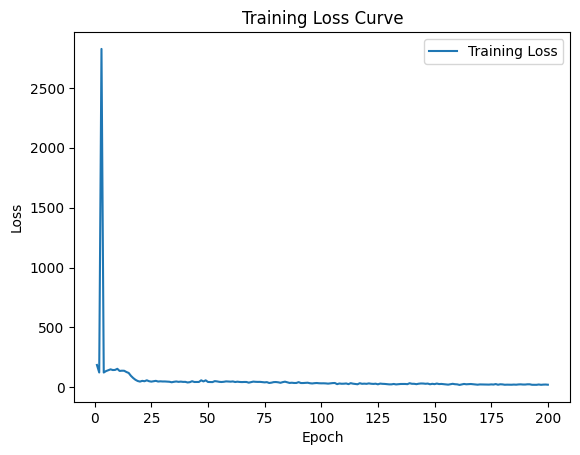

In [45]:
plot_loss(EPOCHS,loss_record)

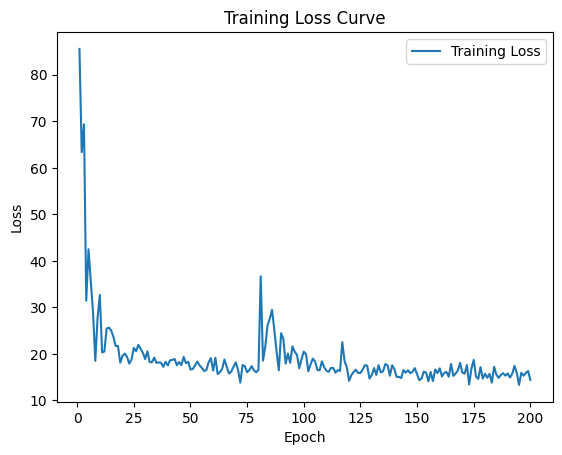

In [13]:
#loss without normalization 256
plot_loss(EPOCHS,loss_record)

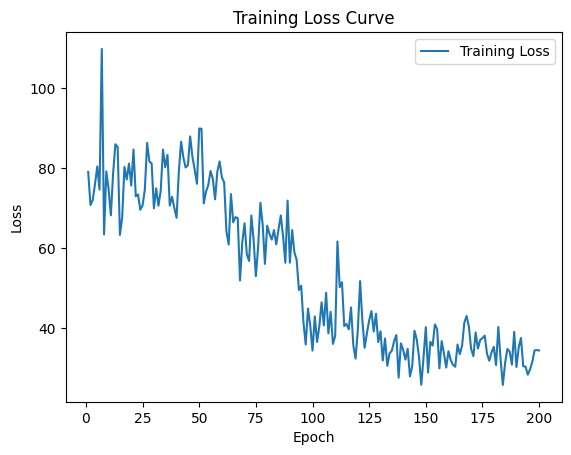

In [20]:
#loss with normalization 256
plot_loss(EPOCHS,loss_record)

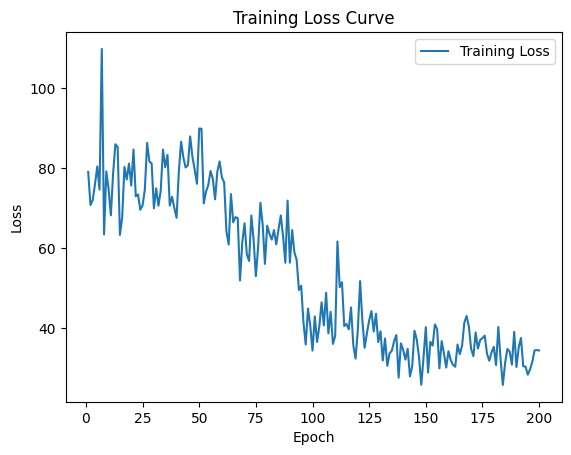

In [20]:
#loss with normalization 256
plot_loss(EPOCHS,loss_record)

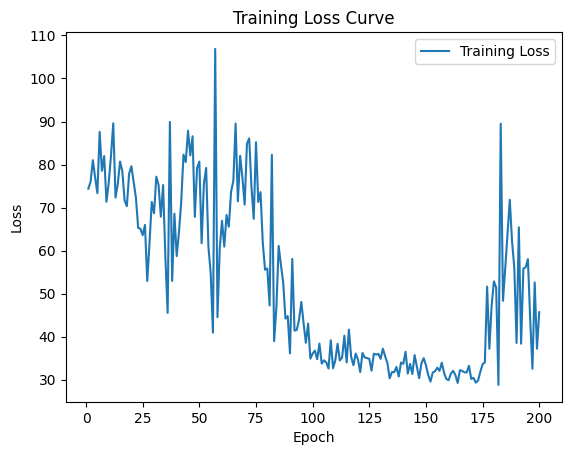

In [27]:
#loss with minmax 256
plot_loss(EPOCHS,loss_record)

In [15]:
unet_score = unet_trainer.test(testloader)

print(f'Dice Score {unet_score}')

Dice Score 1.9920061403071314


In [16]:
data=image_dataset.__getitem__(16)

In [17]:
image=data['input_image'].view((1, 1, 1024, 1024))

In [18]:
output=unet_trainer.model(data['input_image'].view((1, 1, 1024, 1024)))

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [37]:
 image.shape

torch.Size([1, 1, 1024, 1024])

torch.Size([3, 1024, 1024])
torch.Size([3, 1, 1024, 1024])


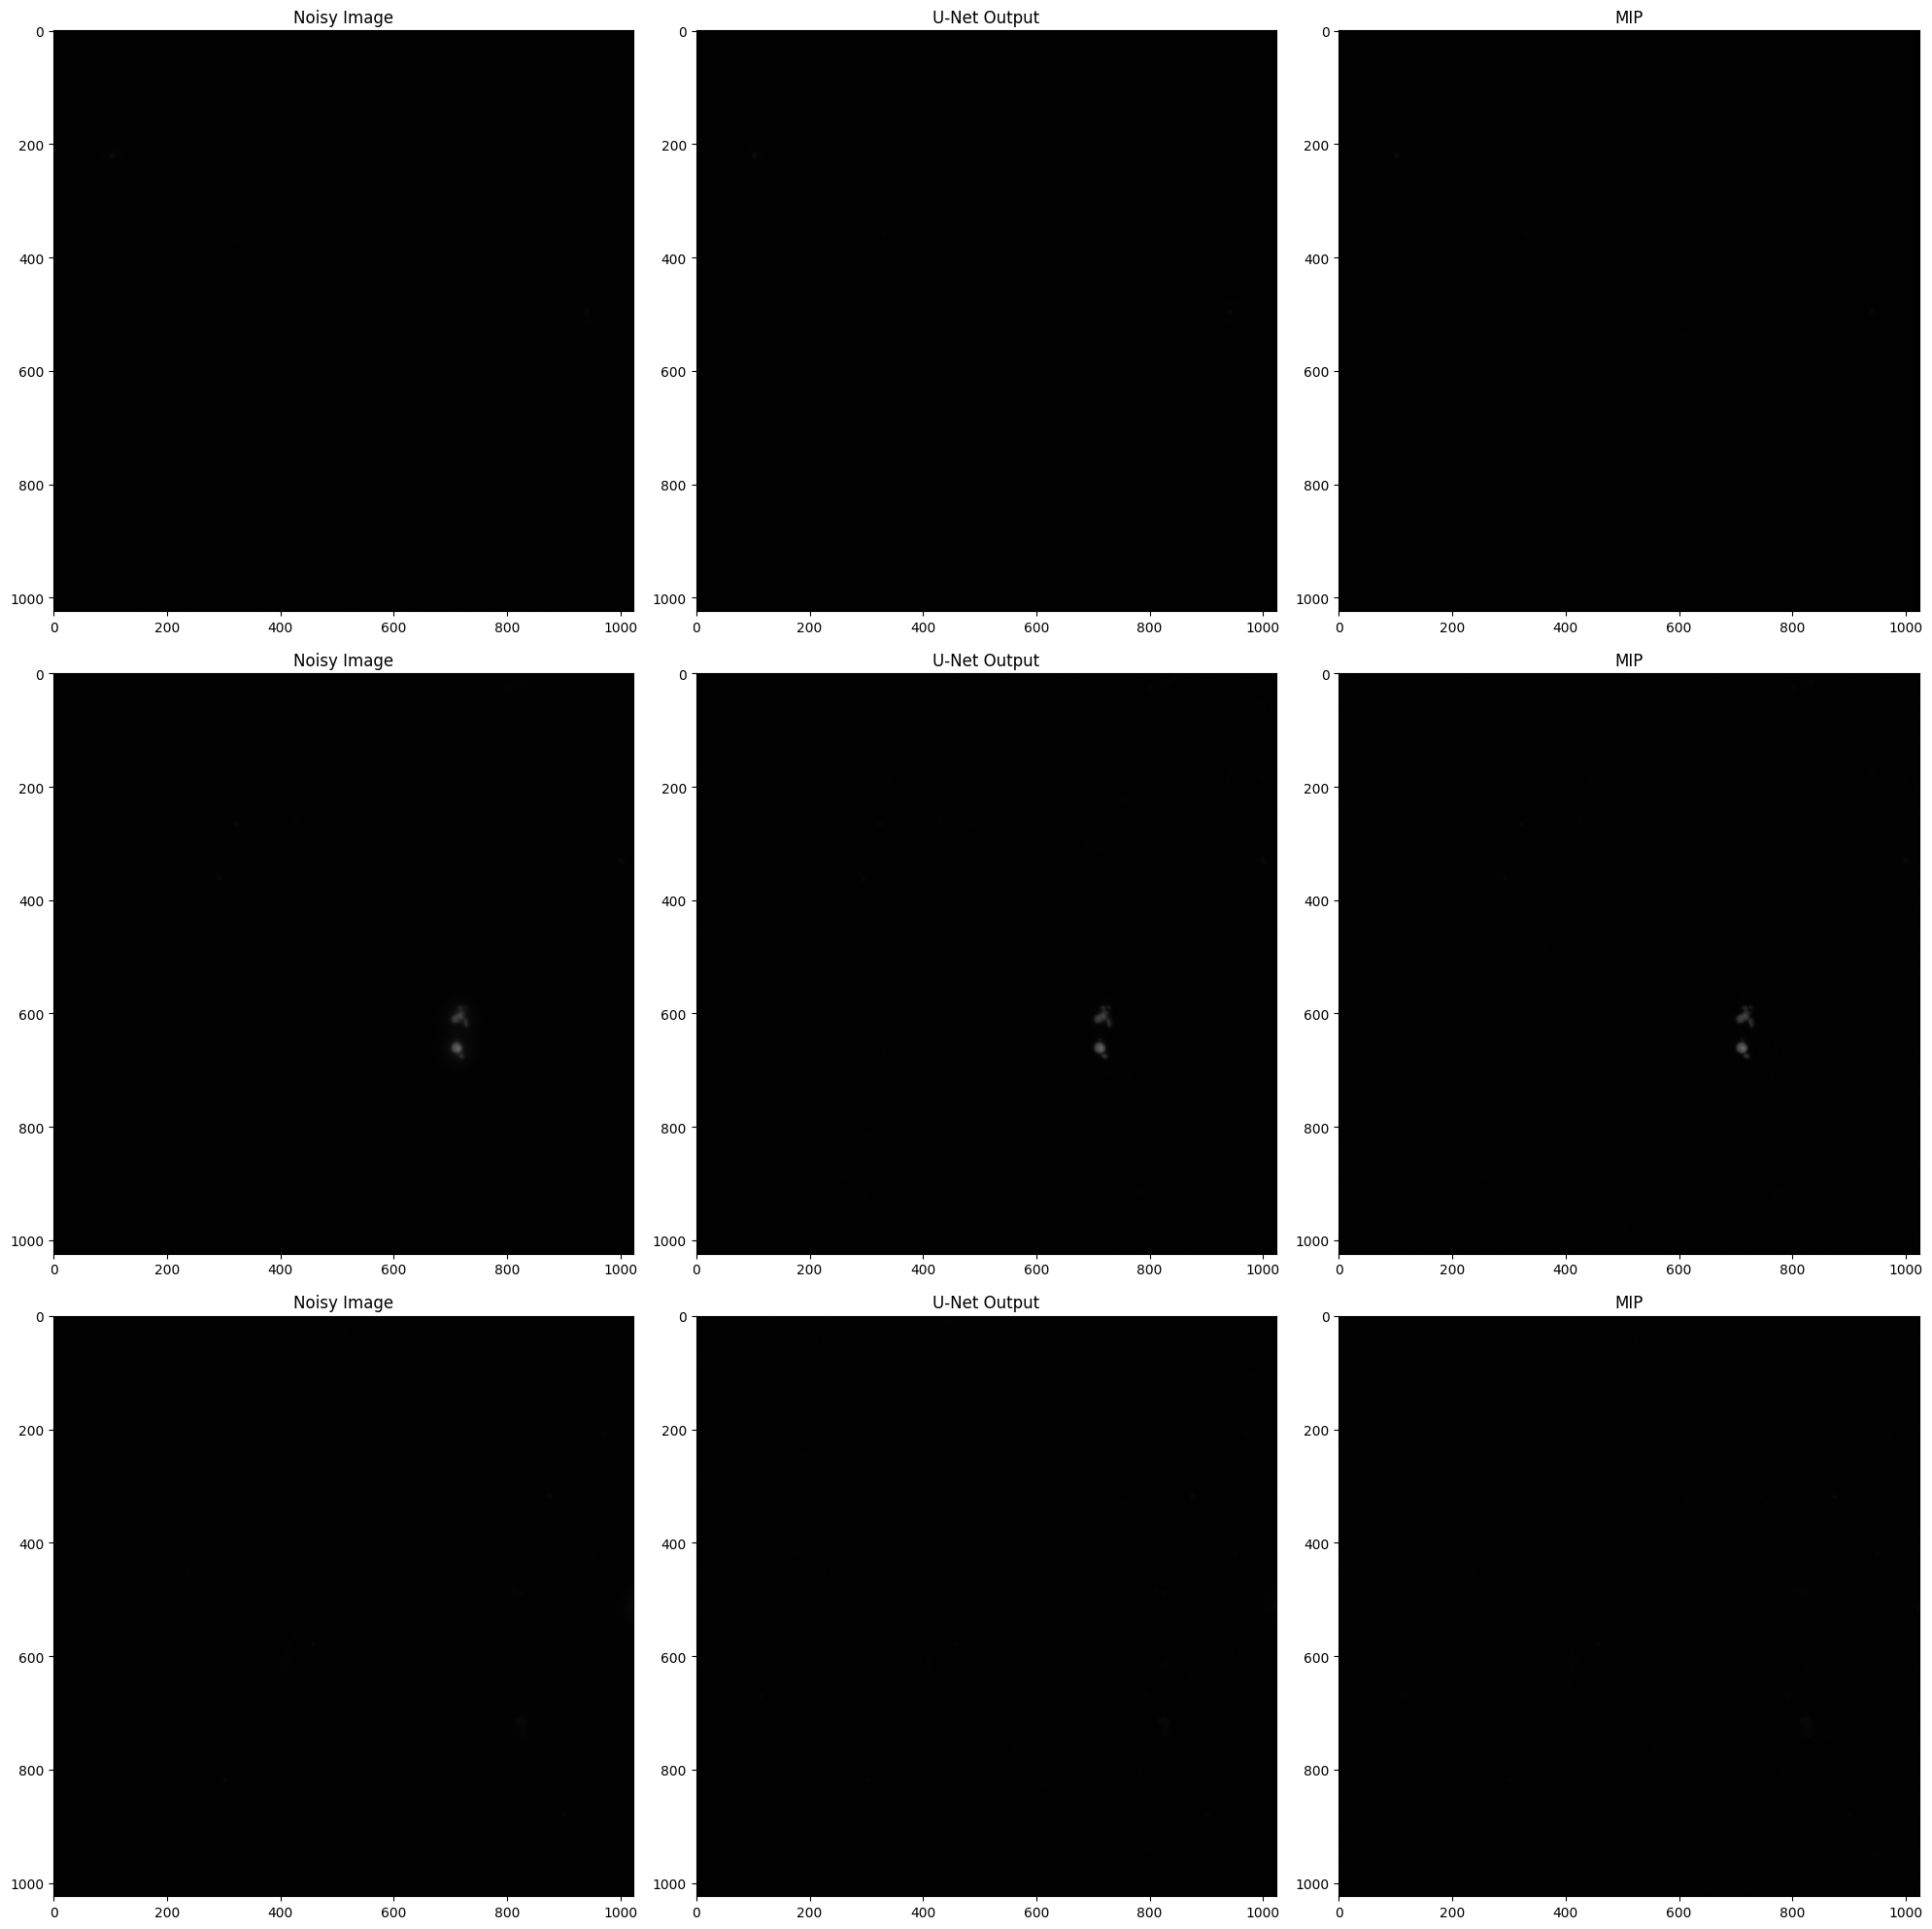

In [69]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))


for data in testloader:
    
    
    output=unet_trainer.model(data['input_image'].to(device))
    print(data['input_image'].squeeze(1).shape)

    input_image = data['input_image'].squeeze().permute(1, 2, 0).detach()
    print(data['input_image'].shape)
    output_image = data['output_image'].squeeze().permute(1, 2, 0)

    model_output=output.cpu().squeeze().permute(1, 2, 0).detach()
    
    for i in range(input_image.shape[2]):
        ax[i,0].set_title('Noisy Image')
        ax[i,1].set_title('U-Net Output')
        ax[i,2].set_title('MIP')
        ax[i,0].imshow(input_image[:,:,i], cmap='gray', vmin=0, vmax=16383, aspect='equal' )
        ax[i,1].imshow(model_output[:,:,i], cmap='gray', vmin=0, vmax=16383, aspect='equal')
        ax[i,2].imshow(output_image[:,:,i], cmap='gray', vmin=0, vmax=16383, aspect='equal')

    break
    

plt.tight_layout()

In [49]:
plt.savefig('myfig')

<Figure size 640x480 with 0 Axes>

In [55]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms 

In [67]:
def calculate_psnr_batch(tensor_original, tensor_compressed, max_val=1.0):
    # Ensure tensors have the same shape
    min_height = min(tensor_original.shape[2], tensor_compressed.shape[2])
    min_width = min(tensor_original.shape[3], tensor_compressed.shape[3])

    tensor_original = tensor_original[:, :, :min_height, :min_width]
    tensor_compressed = tensor_compressed[:, :, :min_height, :min_width]

    # Calculate mean squared error
    mse = F.mse_loss(tensor_original, tensor_compressed, reduction='none')
    mse = mse.view(mse.size(0), -1).mean(dim=1)

    # Calculate PSNR
    psnr = 20 * torch.log10(max_val / torch.sqrt(mse))

    return psnr

In [70]:
total_psnr = 0.0
dataset_size=0
for batch in testloader:
    dataset_size+=len(batch)
    # Apply transformations if necessary
    unet=unet_trainer.model(data['input_image'].to(device))
    mip =data['output_image'].to(device)

    psnr_batch = calculate_psnr_batch(unet, mip)
    total_psnr += psnr_batch.sum().item()
    break
    

average_psnr = total_psnr / dataset_size
print(f"Average PSNR: {average_psnr} dB")

Average PSNR: -19.854119618733723 dB
